# Cache Status

## Converting data

**CacheStatus:** Convert data from a tables in a bunch of html files (CacheStatus.*.html)

First install dependency used in scripts below and import everything what is needed in this notebook

In [11]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [1]:
from datetime import datetime
from bs4 import BeautifulSoup
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
# Set the directory containing the HTML files
directory = "CacheStatus"

# Initialize an empty list to store the CSV data
csv_data = []

# Initialize a flag to check if the header row has been added
header_added = False

# Loop through each HTML file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".html"):
        # Remove 'CacheStatus.' and 'RenderingsStatistics.' from the filename
        timestamp_str = filename.replace("CacheStatus.", "").replace("RenderingsStatistics.", "")
        # Parse the timestamp from the file name
        timestamp_str = timestamp_str.rsplit(".", 1)[0]
        timestamp = datetime.strptime(timestamp_str, "%Y%m%dZ.%H%M%SZ")

        # Read the HTML file
        with open(os.path.join(directory, filename), "r") as f:
            html = f.read()

        # Parse the HTML with BeautifulSoup
        soup = BeautifulSoup(html, "html.parser")

        # Find all tables in the HTML
        tables = soup.find_all("table")

        # Loop through each table
        for table in tables:
            # Find all rows in the table
            rows = table.find_all("tr")

            # Loop through each row
            for i, row in enumerate(rows):
                # Find all columns in the row
                cols = row.find_all(["th", "td"])

                # Initialize an empty list to store the column data
                col_data = []

                # Loop through each column
                for col in cols:
                    # Append the column data to the list
                    col_data.append(col.get_text().strip())

                # Skip the first row if the header row has already been added
                if i == 0 and header_added:
                    continue

                # Append the timestamp to the column data
                col_data.append(timestamp.strftime("%Y-%m-%d %H:%M:%S"))

                # Append the column data to the CSV data
                csv_data.append(col_data)

        # Set the flag to True if the header row has not been added yet
        if not header_added:
            header_added = True

# Write the CSV data to a file
with open("cacheStatus.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_data)

Fix Timestamp column name

In [16]:
with open('cacheStatus.csv', 'r') as f:
    reader = csv.reader(f)
    rows = list(reader)

# Replace the header value for the last column with "timestamp"
header_row = rows[0]
header_row[-1] = "timestamp"

with open('cacheStatus.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

Normalize data from ```cacheStatus.csv``` to convert Size and MaxSize fields to Bytes one and store in new csv: ```cacheStatusNormalized.csv```

In [17]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv('cacheStatus.csv')

# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define a dictionary to map unit strings to their corresponding multipliers
unit_multipliers = {"bytes": 1, "KB": 1024, "MB": 1024**2, "GB": 1024**3}

# Define a function to convert a size string to bytes
def size_to_bytes(size_str):
    try:
        size, unit = size_str.split()
        size = float(size)
    except (ValueError, TypeError):
        return None
    return int(size * unit_multipliers[unit])

# Convert the Size and MaxSize columns to bytes
df["Size"] = df["Size"].apply(size_to_bytes)
df["MaxSize"] = df["MaxSize"].apply(size_to_bytes)

# Filter out any rows where Size is None or either Size or MaxSize is equal to 0
df = df[df["Size"].notnull() & (df["Size"] != 0) & (df["MaxSize"] != 0)]

df.to_csv("cacheStatusNormalized.csv", index=False)

# Filter the DataFrame to only include rows where Size is >= 80% of MaxSize
#filtered_df = df[df["Size"] >= 0.8 * df["MaxSize"]]

# Convert the Size and MaxSize columns to MB
#filtered_df["Size"] = filtered_df["Size"] / 1024**2
#filtered_df["MaxSize"] = filtered_df["MaxSize"] / 1024**2

#filtered_df.to_csv("cacheAlmostFull.csv", index=False)

# Print a message to confirm that the file was saved
print("Filtered data saved to cacheStatusNormalized.csv")

Filtered data saved to cacheStatusNormalized.csv


## Analyze caches
### Find caches filled more than 80% of MaxSize

Below is the script to create a data frame filtered by datetime. E.g. you can have a lot of statistics data but would like to analyze and plot data only for certain datetime range
The data will be than stored in the variable ```df``` that can be accessed on the scripts below. Make sure not to modify the values of that variable so that other scripts can work with initial values

In [2]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv('cacheStatusNormalized.csv')

# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

######## Set desired Date-time range to plot chart for. Comment out all the lines below to plot entire dataset.
# Set the start and end datetimes for the desired datetime range
start_datetime = pd.Timestamp('2023-06-07 13:40:00')
end_datetime = pd.Timestamp('2023-06-07 14:50:00')
# Filter the dataframe to only include rows within the desired datetime range
df = df[(df['timestamp'] >= start_datetime) & (df['timestamp'] <= end_datetime)]

In the code below, let's find the cache row entries that have size values 80% more than MaxSize of the cache. They will be rendered to the csv file ```cacheAlmostFull.csv```

In [4]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv('cacheStatusNormalized.csv')

# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define a dictionary to map unit strings to their corresponding multipliers
unit_multipliers = {"bytes": 1, "KB": 1024, "MB": 1024**2, "GB": 1024**3}

df80 = df

# Filter the DataFrame to only include rows where Size is >= 80% of MaxSize
filtered_df = df80[df80["Size"] >= 0.8 * df80["MaxSize"]]

# Convert the Size and MaxSize columns to MB
filtered_df["Size"] = filtered_df["Size"] / 1024**2
filtered_df["MaxSize"] = filtered_df["MaxSize"] / 1024**2

filtered_df.to_csv("cacheAlmostFull.csv", index=False)

# Print a message to confirm that the file was saved
print("Filtered data saved to cacheAlmostFull.csv")

Filtered data saved to cacheAlmostFull.csv


/tmp/ipykernel_4977/669217640.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Size"] = filtered_df["Size"] / 1024**2
/tmp/ipykernel_4977/669217640.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["MaxSize"] = filtered_df["MaxSize"] / 1024**2


# Plotting data

The promt example that can be used to create sample python script for using in the Jupyter Notebook. Make sure appropriate csv file is opened so that copilot knows the context.

```for the data from merged.csv create chart showing trend for name column over timesatamp on MaxSize metric. Consider only name values equal to web[items])```

Lets introduce several variables that can be use for limiting the datetime range for data plotting

In [5]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv('cacheStatusNormalized.csv')

# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

######## Set desired Date-time range to plot chart for. Comment out all the lines below to plot entire dataset.
# Set the start and end datetimes for the desired datetime range
start_datetime = pd.Timestamp('2023-06-07 13:40:00')
end_datetime = pd.Timestamp('2023-06-07 14:50:00')
# Filter the dataframe to only include rows within the desired datetime range
df = df[(df['timestamp'] >= start_datetime) & (df['timestamp'] <= end_datetime)]

Let's see trend for ```web[items]``` cache

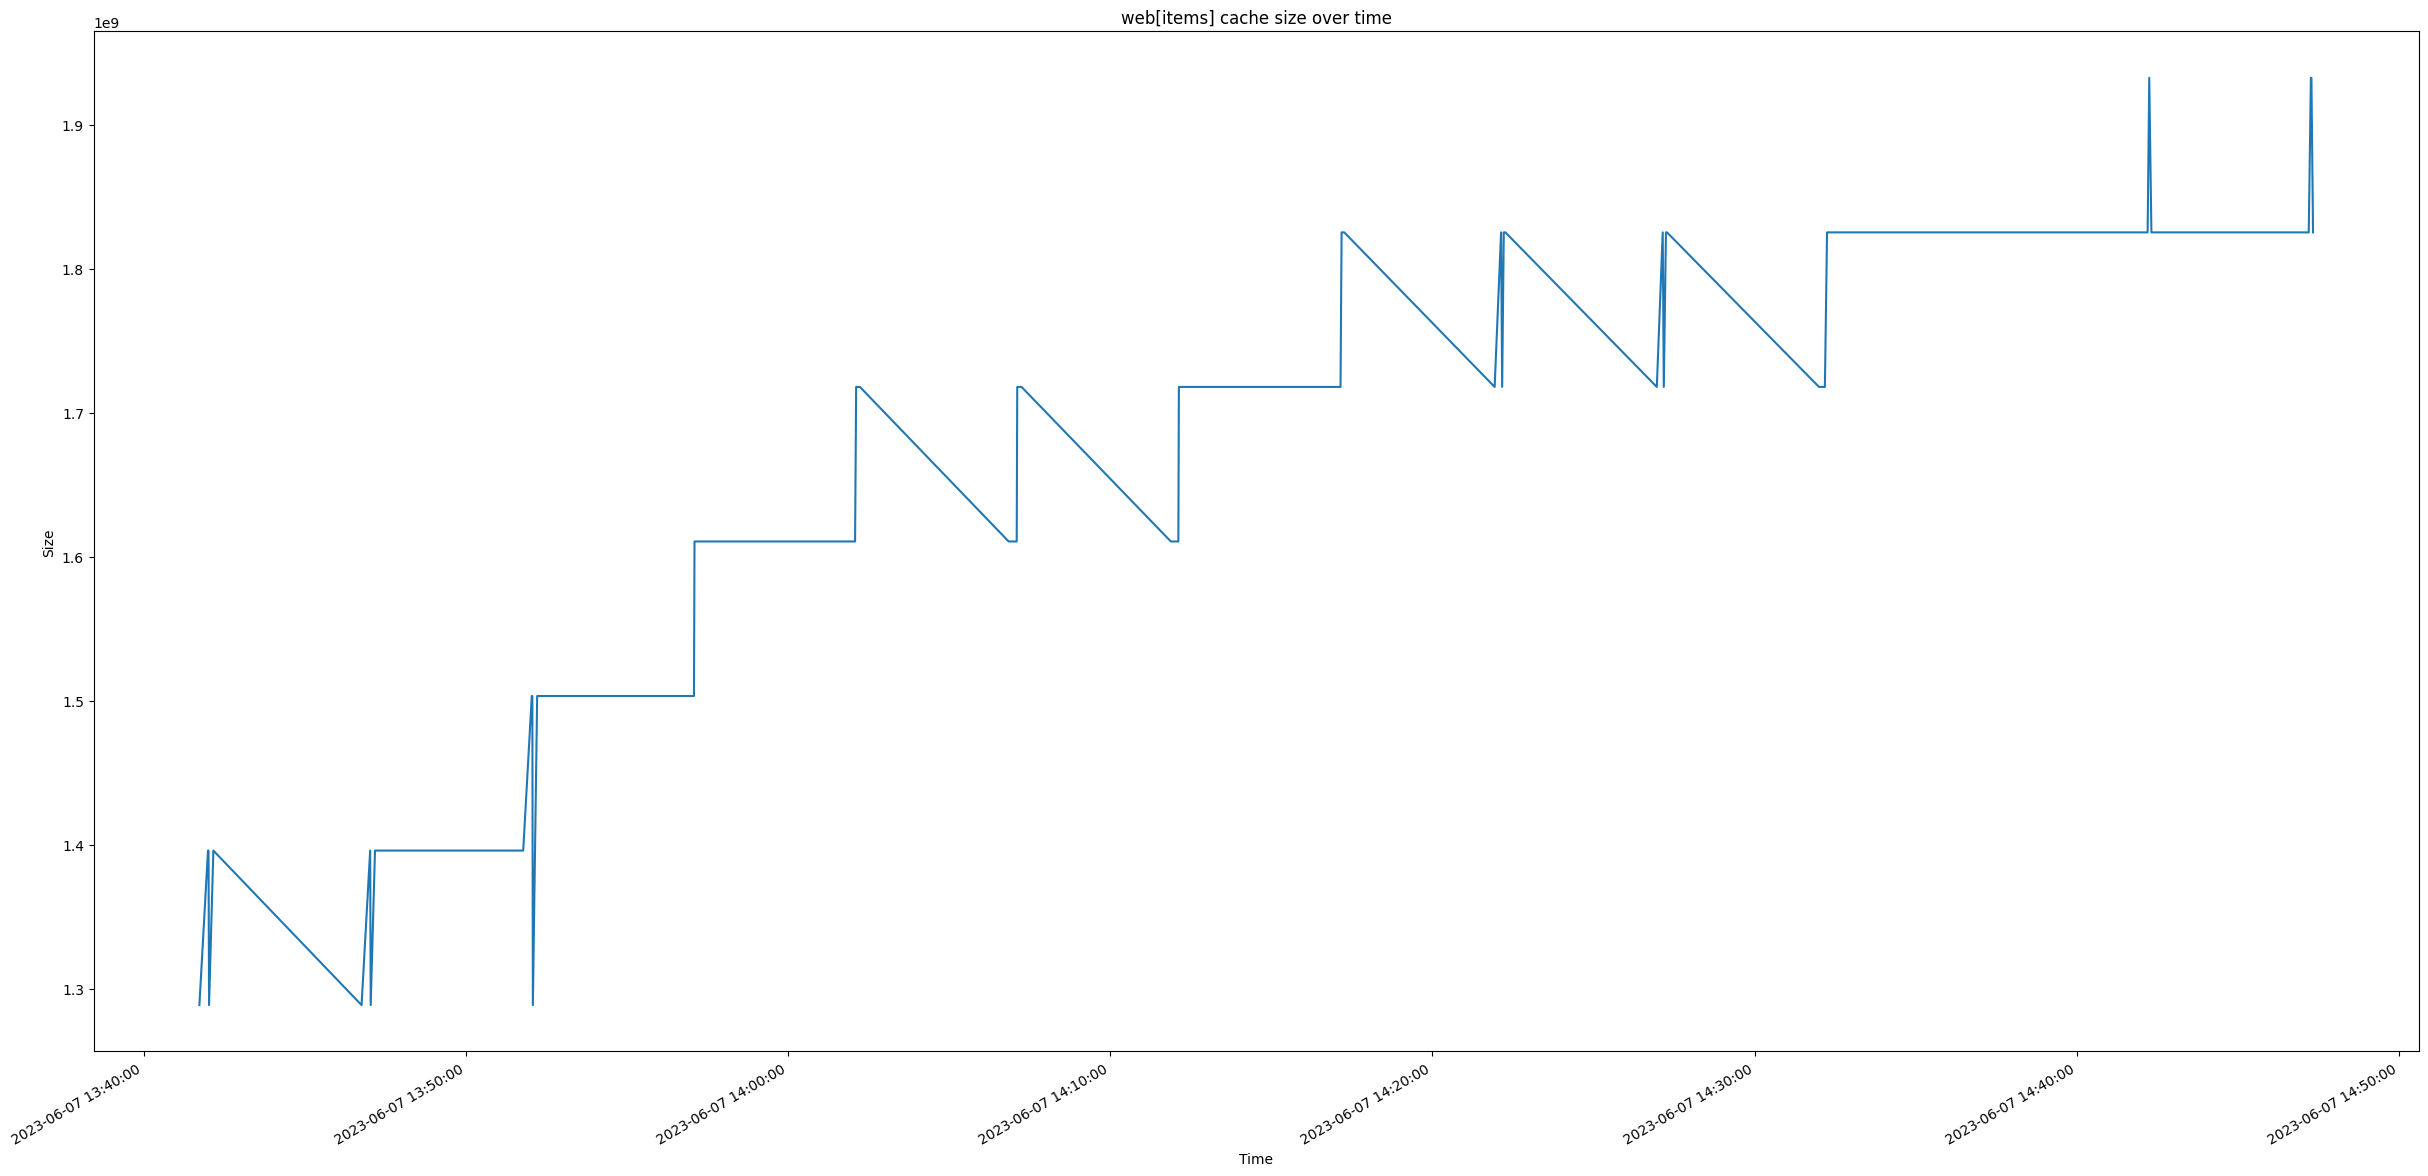

In [3]:
df4 = df

# Set the index of the DataFrame to be the 'timestamp' column
df4=df4[df4['Name'] == 'web[items]']

df4.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Extract the 'Size' column and plot it as a line chart
ax = df4['Size'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('web[items] cache size over time')
plt.xlabel('Time')
plt.ylabel('Size')

# Show the plot
plt.show()

Let's see trend for ```web[data]``` cache

/tmp/ipykernel_5038/2067460888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['timestamp'] = pd.to_datetime(df5['timestamp'])


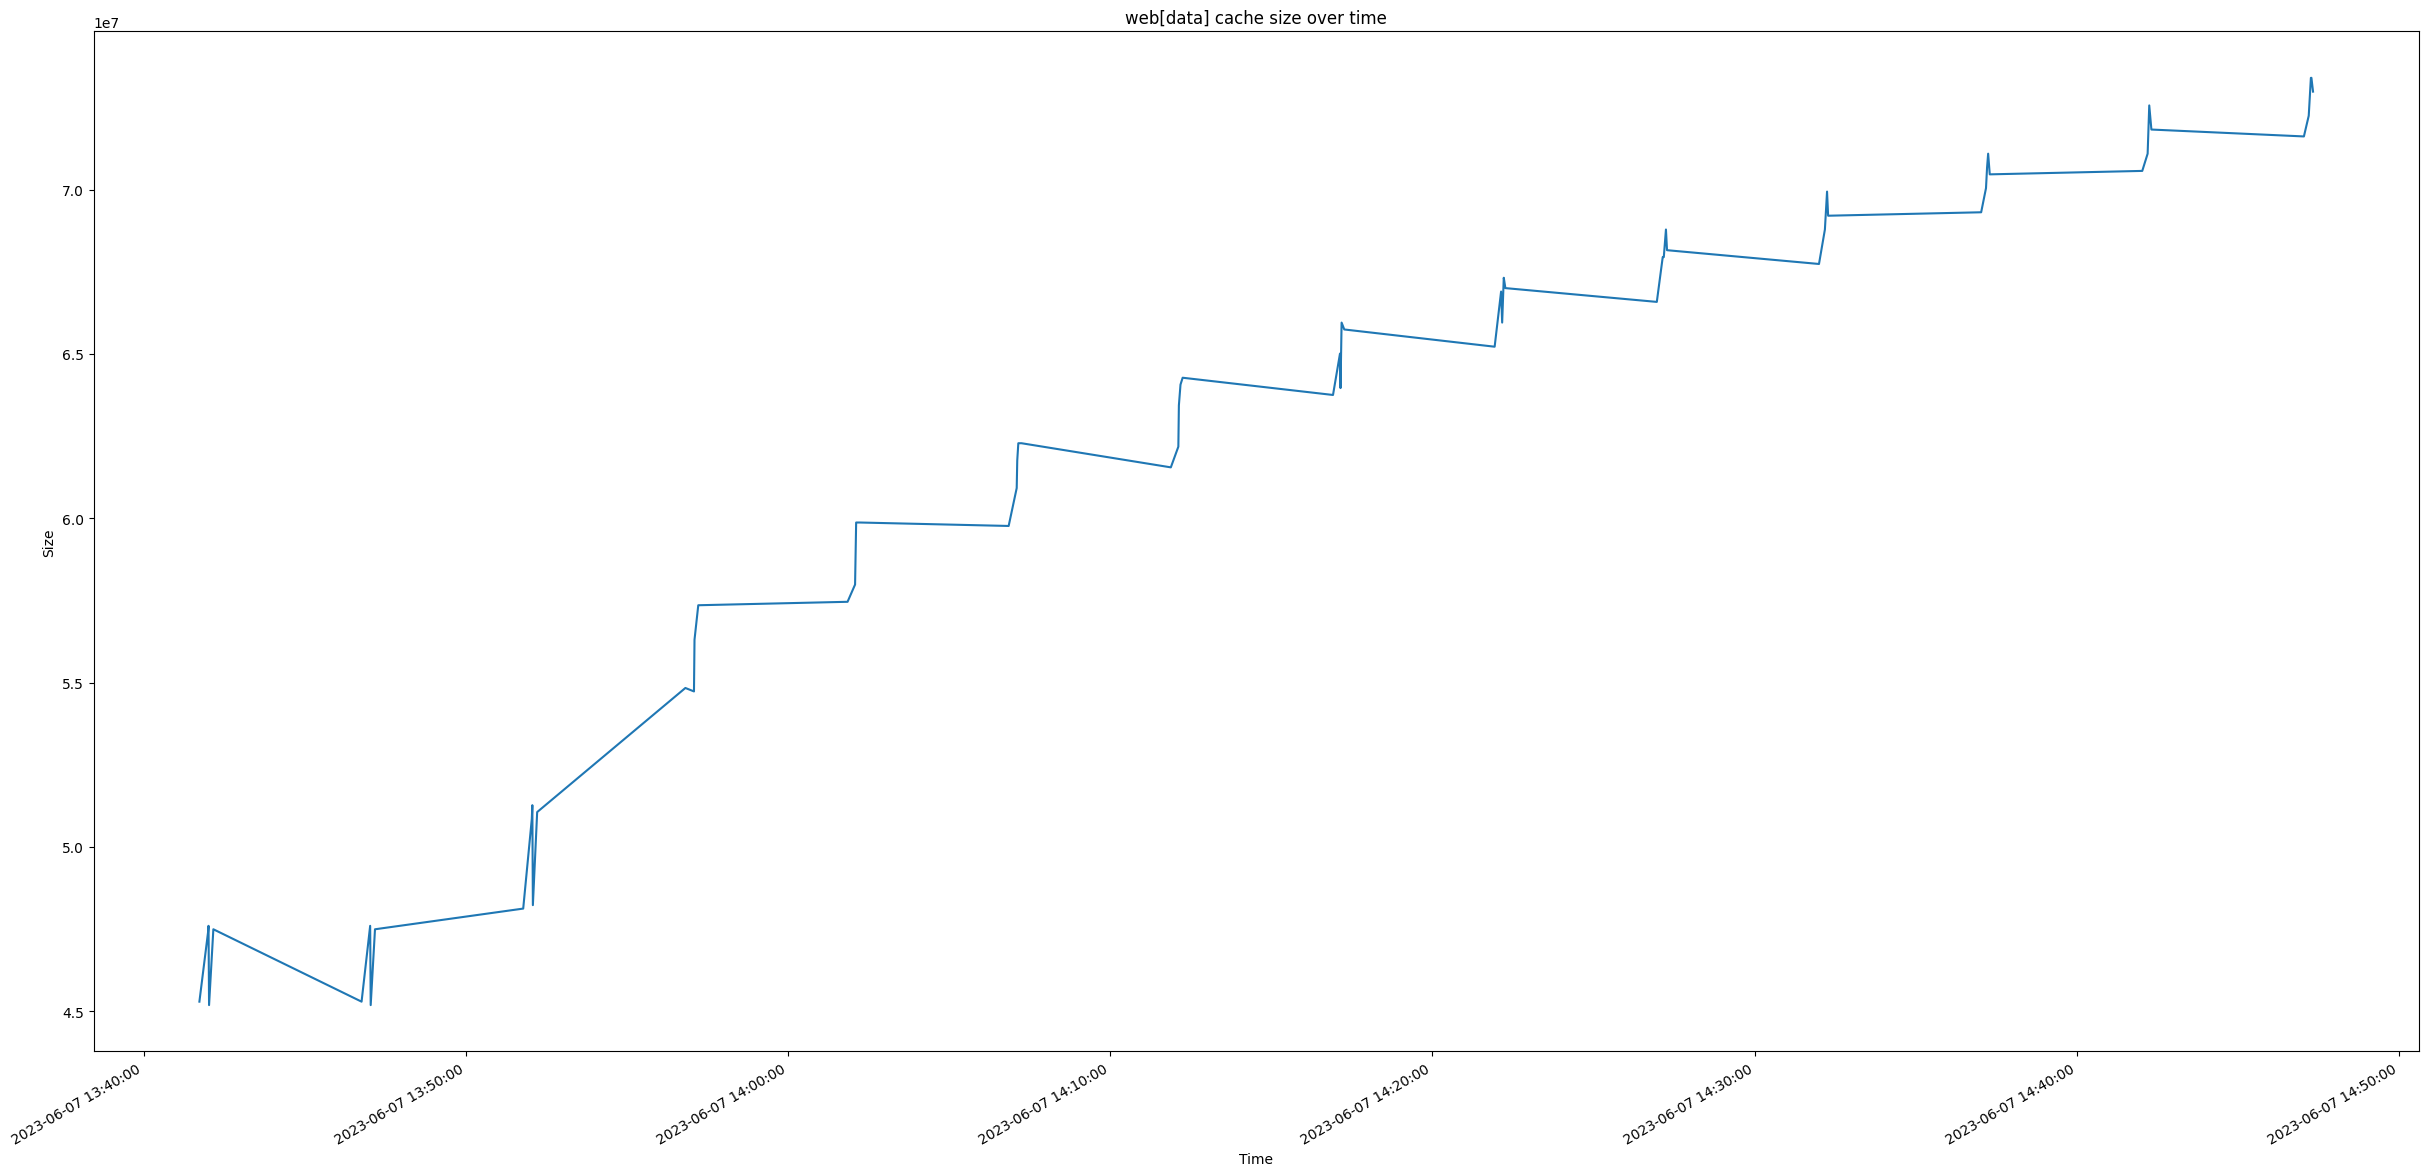

In [36]:
df5 = df

# Set the index of the DataFrame to be the 'timestamp' column
df5=df5[df5['Name'] == 'web[data]']

df5.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Extract the 'Size' column and plot it as a line chart
ax = df5['Size'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('web[data] cache size over time')
plt.xlabel('Time')
plt.ylabel('Size')

# Show the plot
plt.show()

Let's see trend for ```HowdensTrade[html]``` cache

/tmp/ipykernel_5038/4093140514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['timestamp'] = pd.to_datetime(df6['timestamp'])


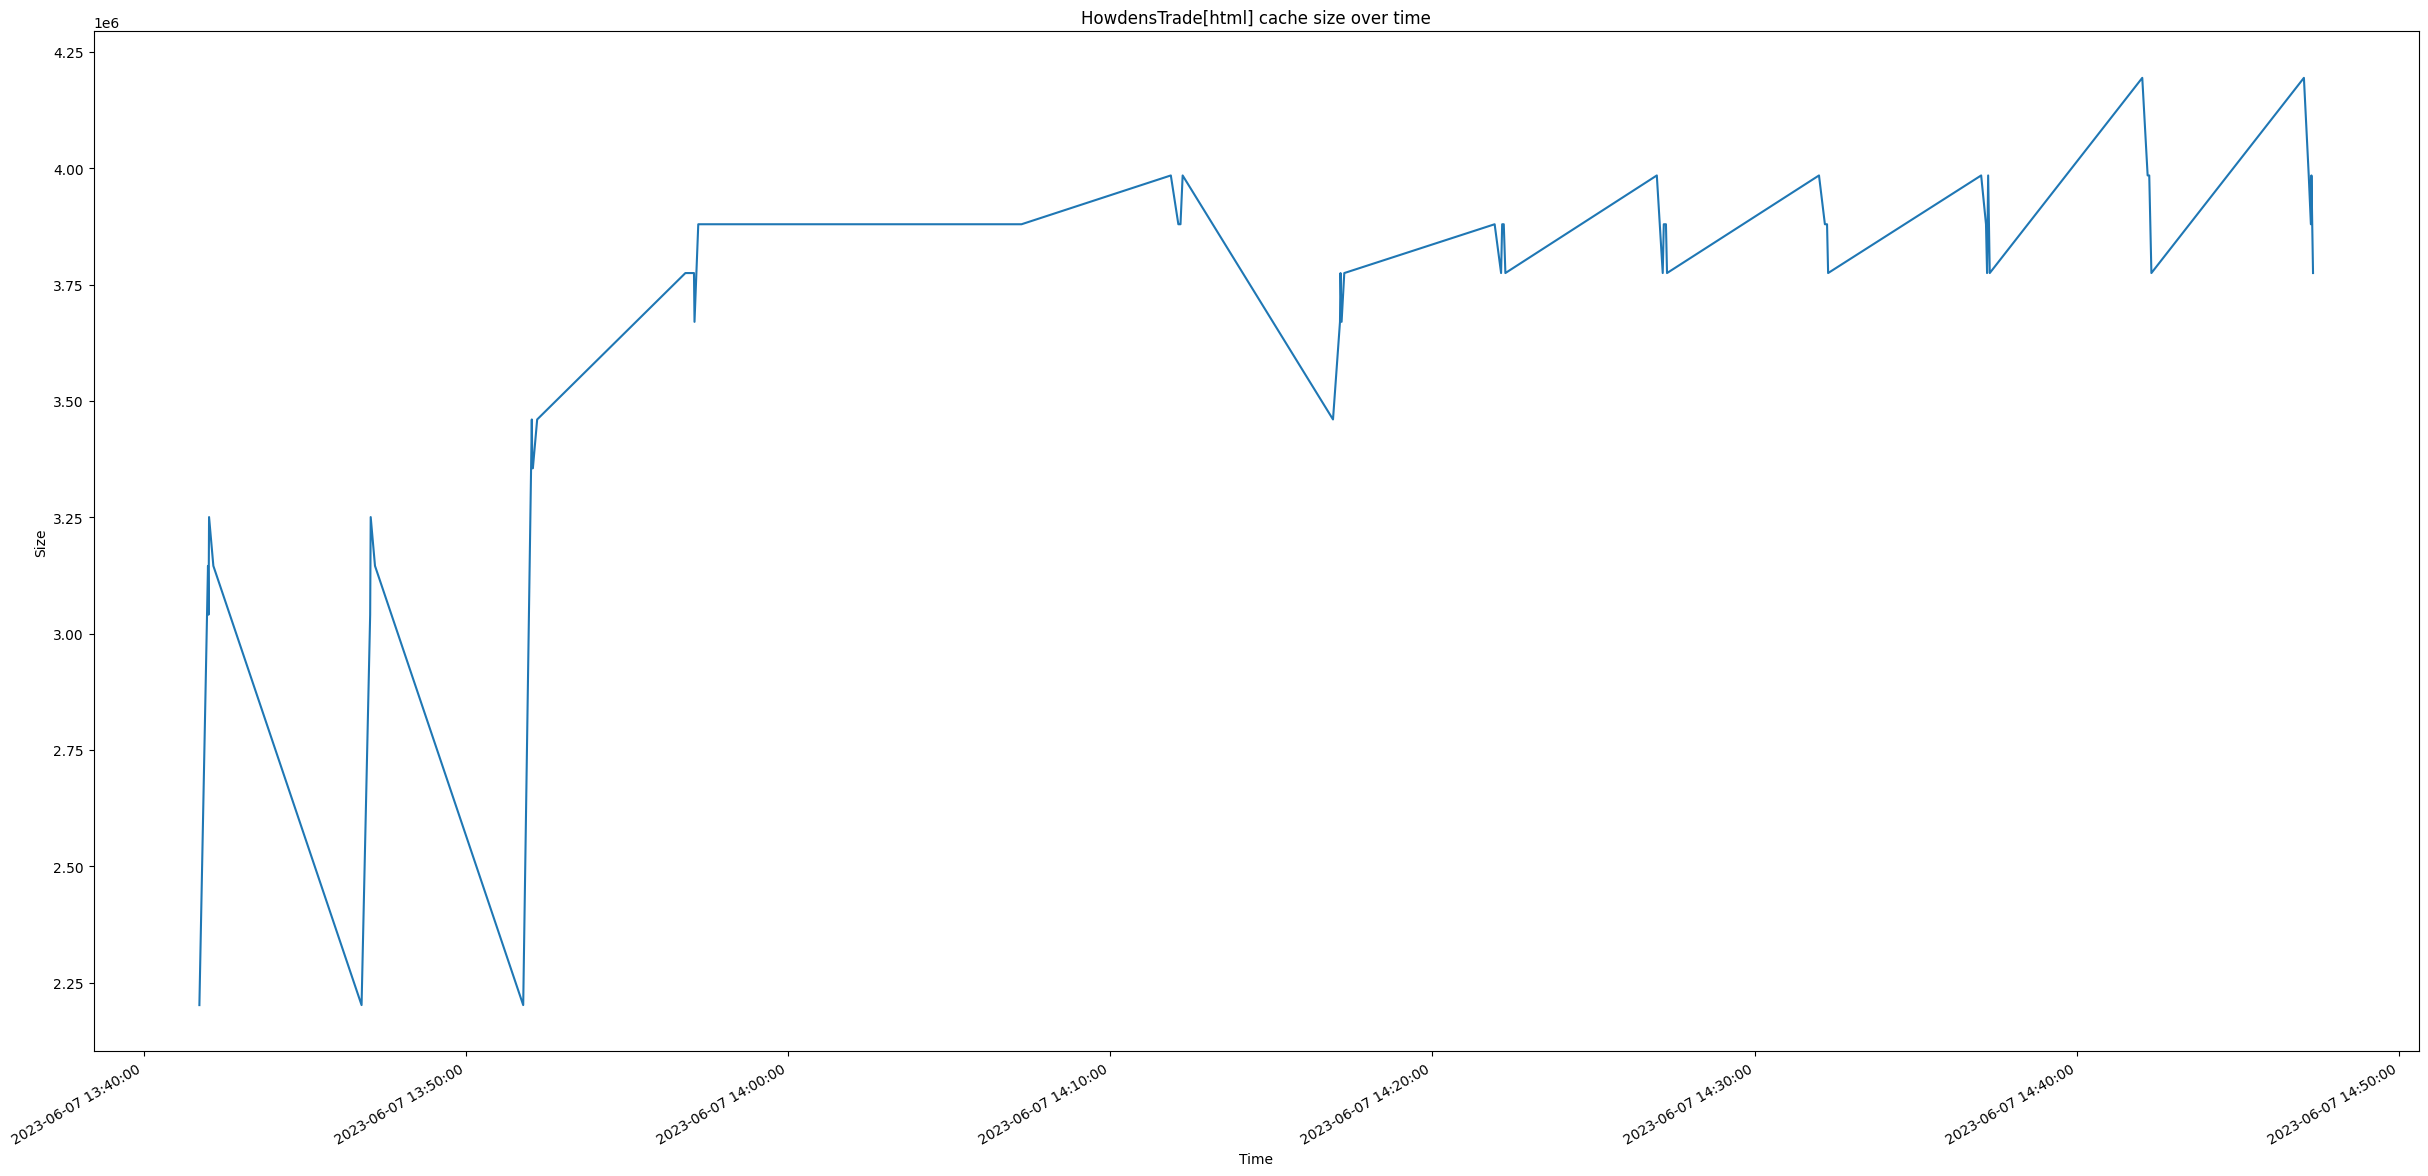

In [30]:
df6 = df

# Set the index of the DataFrame to be the 'timestamp' column
df6=df6[df6['Name'] == 'HowdensTrade[html]']

df6.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Extract the 'Size' column and plot it as a line chart
ax = df6['Size'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('HowdensTrade[html] cache size over time')
plt.xlabel('Time')
plt.ylabel('Size')

# Show the plot
plt.show()

Trend for ```SqlDataProvider - Prefetch data(web)``` cache

/tmp/ipykernel_5038/4081500020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['timestamp'] = pd.to_datetime(df7['timestamp'])


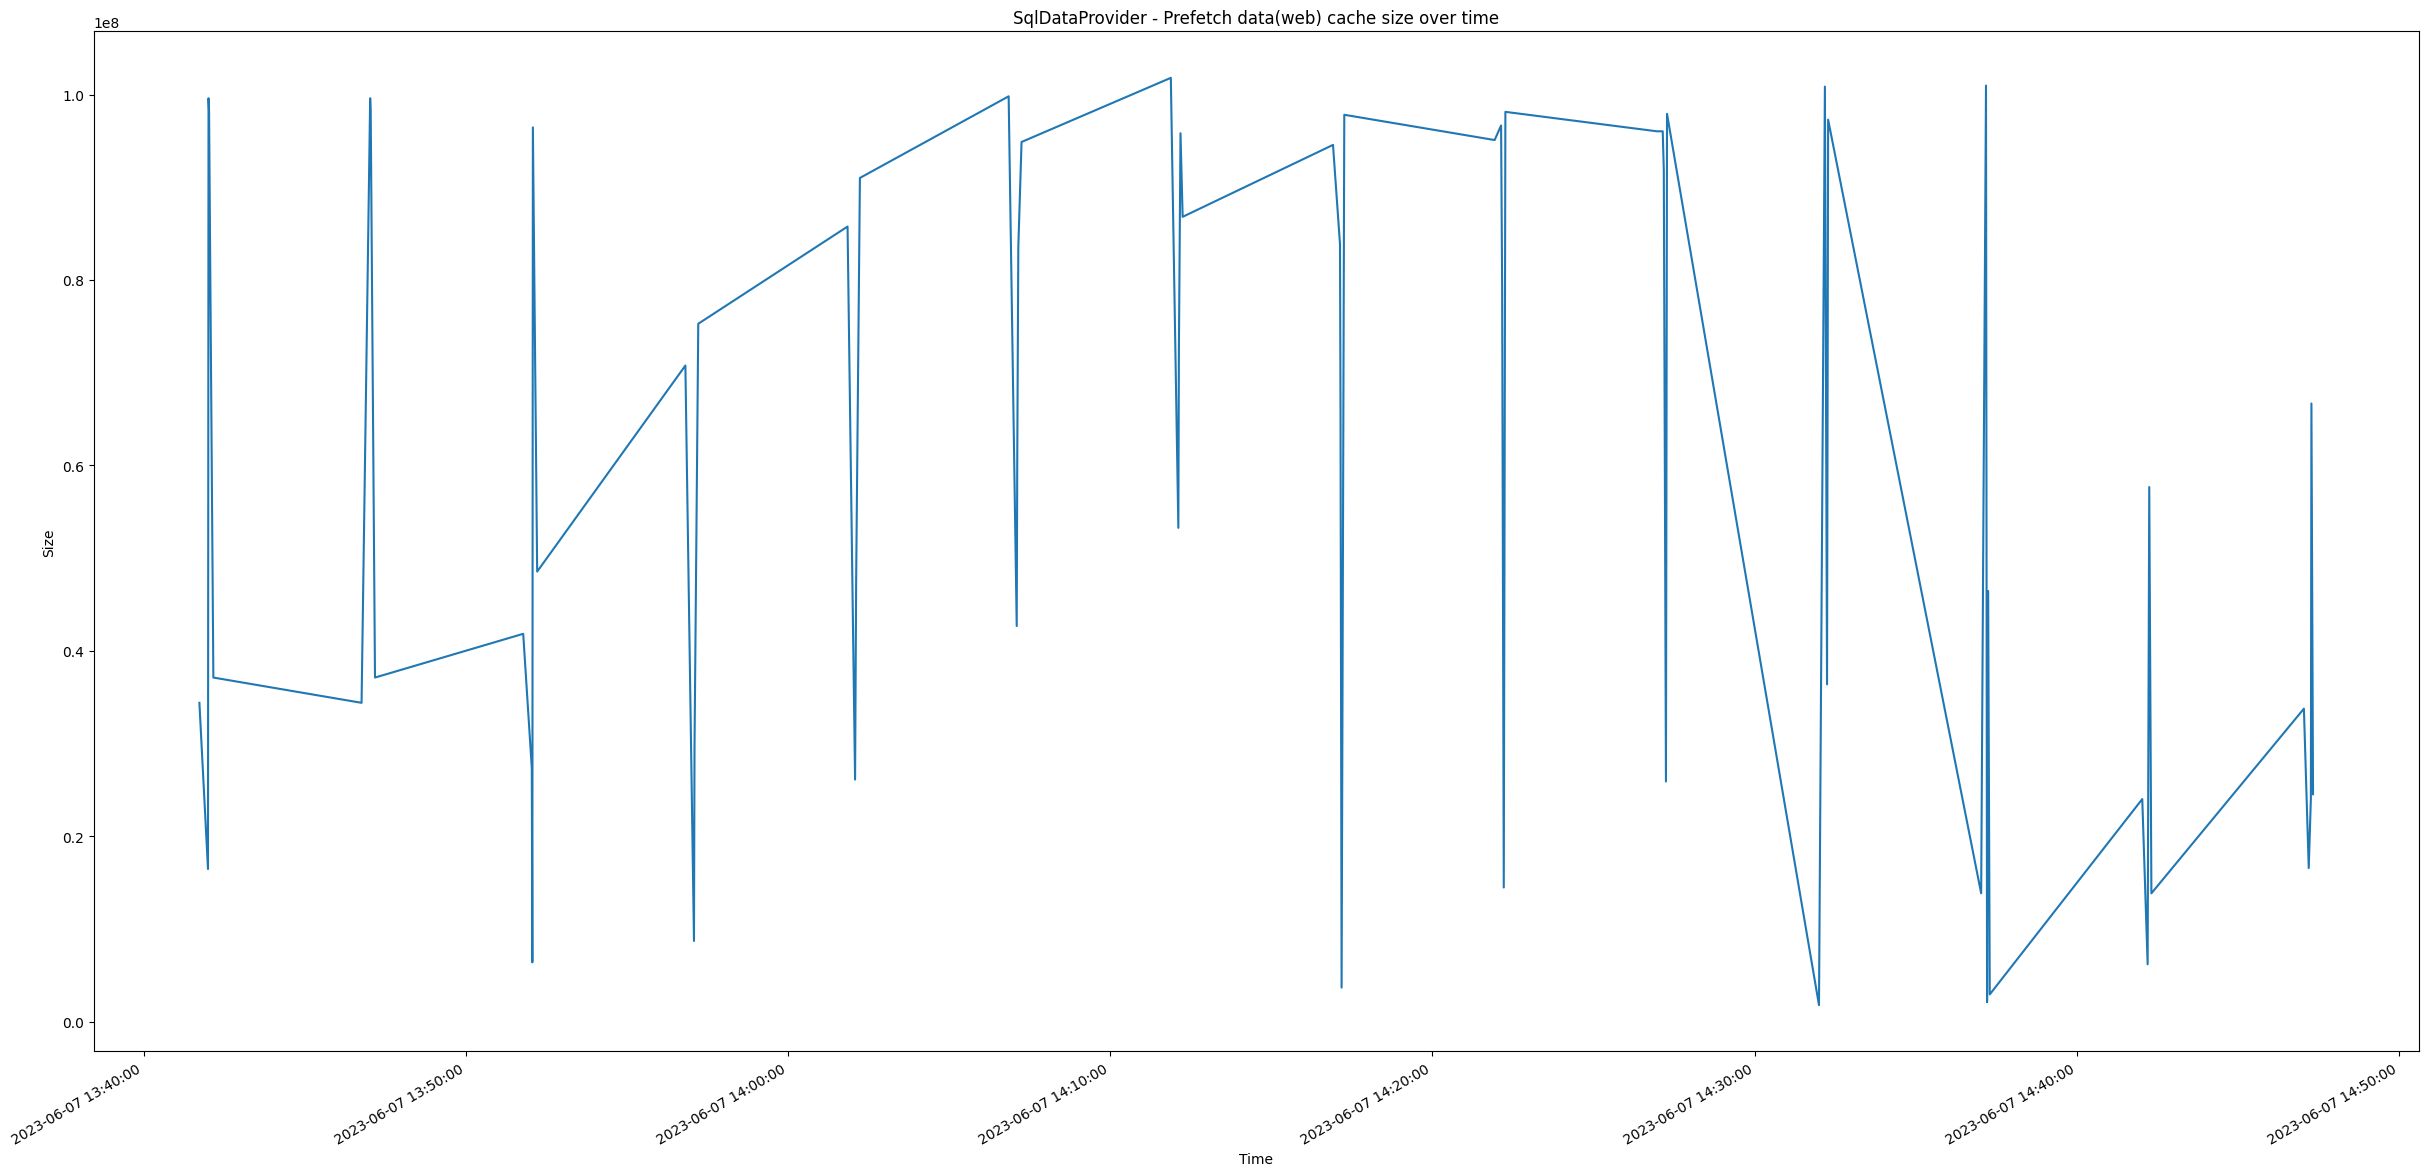

In [32]:
df7 = df

# Set the index of the DataFrame to be the 'timestamp' column
df7=df7[df7['Name'] == 'SqlDataProvider - Prefetch data(web)']

df7.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Extract the 'Size' column and plot it as a line chart
ax = df7['Size'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('SqlDataProvider - Prefetch data(web) cache size over time')
plt.xlabel('Time')
plt.ylabel('Size')

# Show the plot
plt.show()

Trend for ```LAYOUT_DELTA_CACHE``` cache

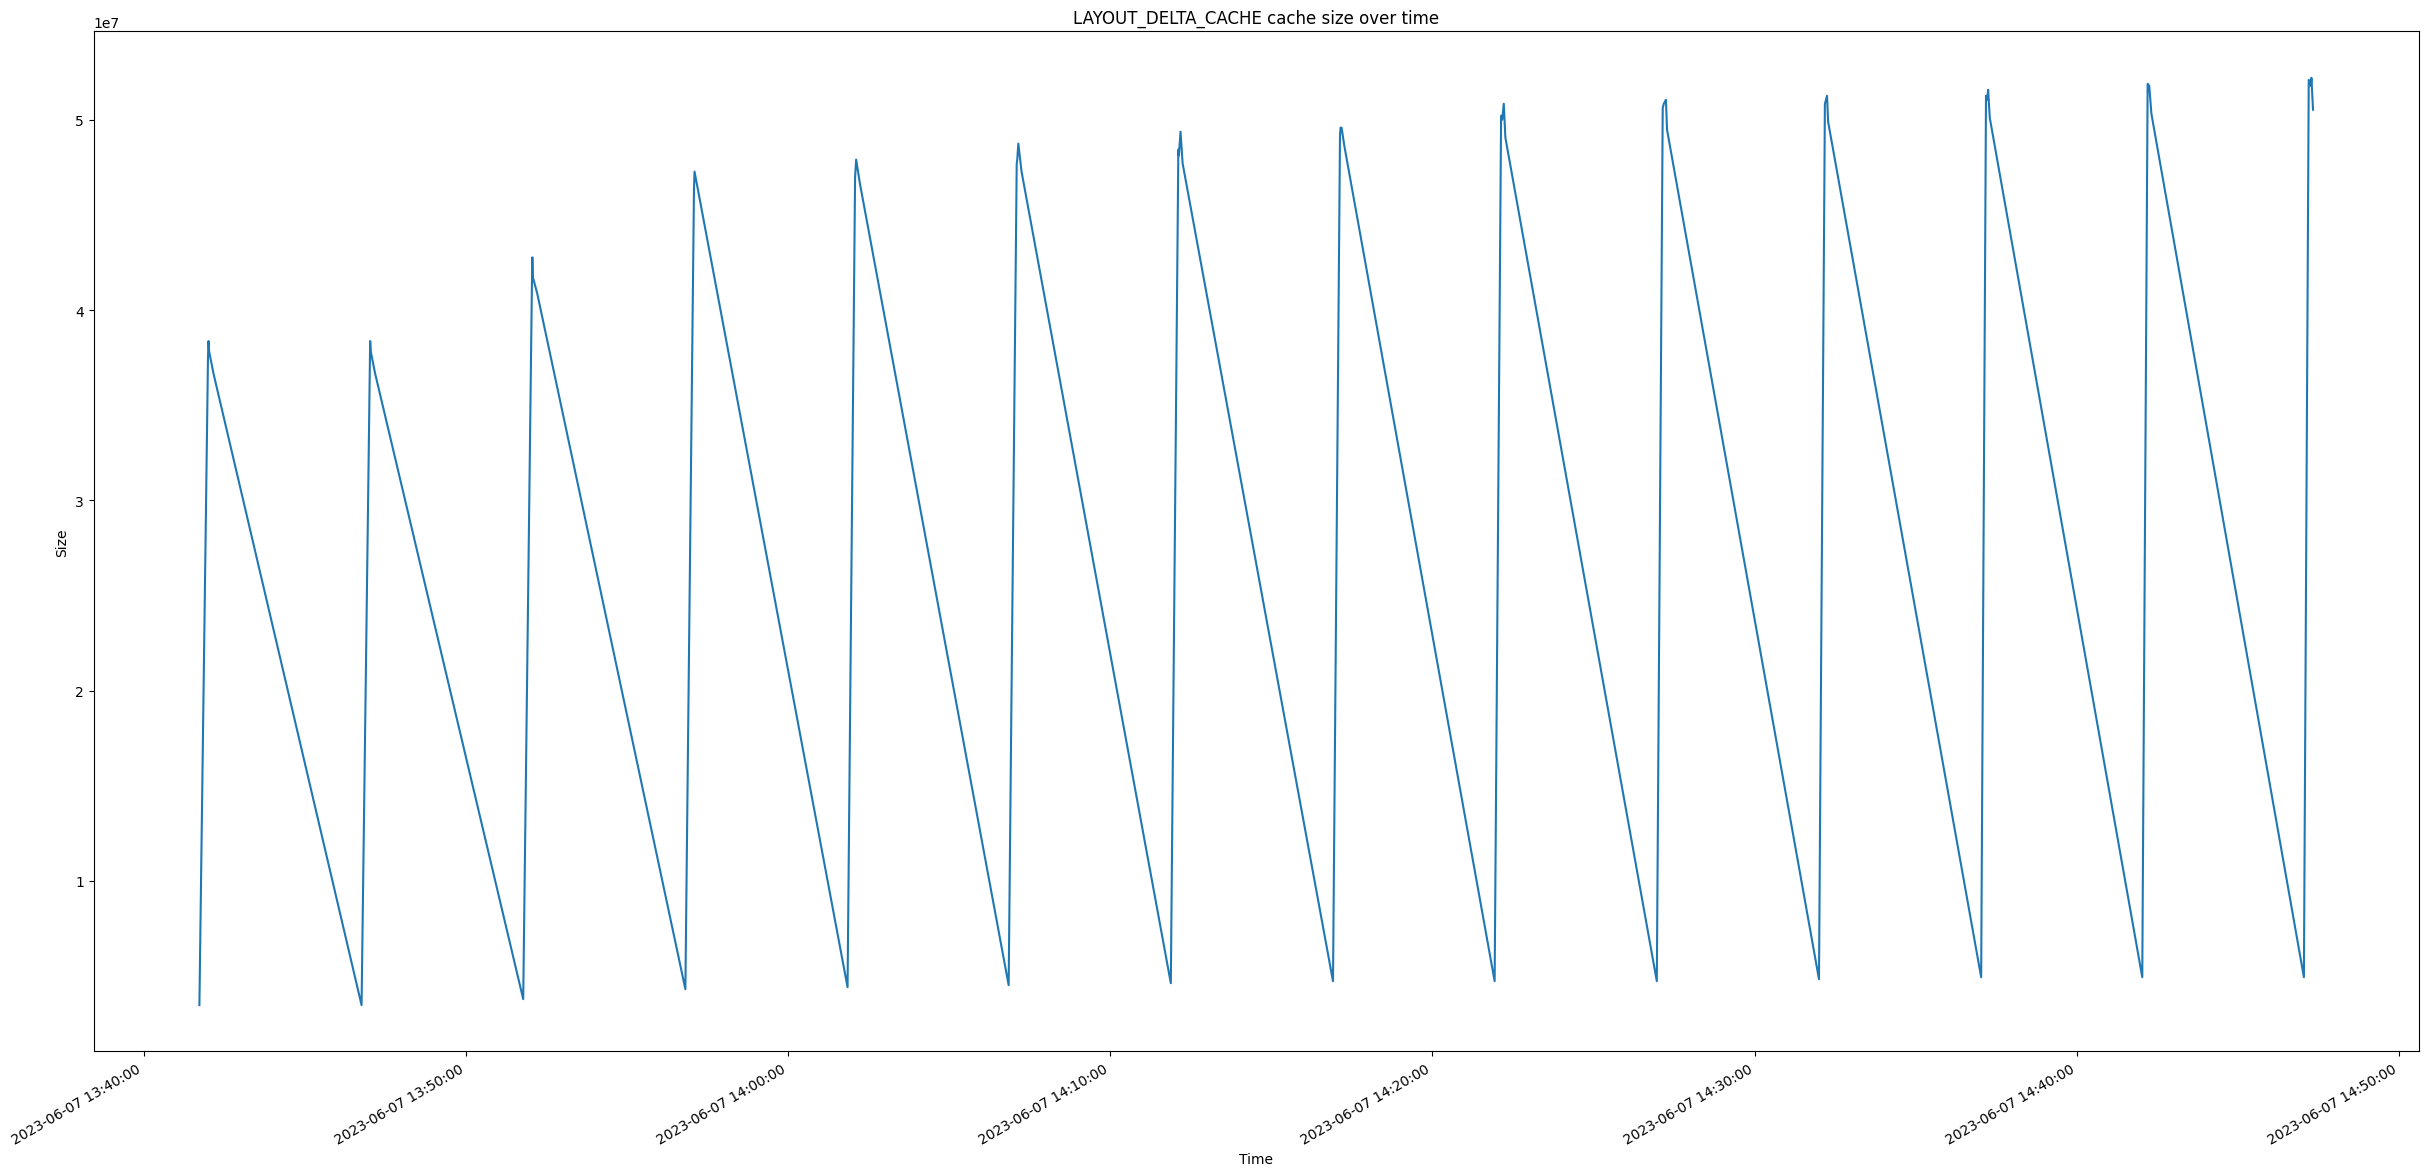

In [37]:
df8 = df

# Set the index of the DataFrame to be the 'timestamp' column
df8=df8[df8['Name'] == 'LAYOUT_DELTA_CACHE']

df8.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Extract the 'Size' column and plot it as a line chart
ax = df8['Size'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('LAYOUT_DELTA_CACHE cache size over time')
plt.xlabel('Time')
plt.ylabel('Size')

# Show the plot
plt.show()